In [3]:
import numpy as np

### Load moments
and 1) filter out huge objects and 2) only keep first Nmax moments

In [5]:
Rgmax=200
Nmax=5

In [9]:
ids = np.genfromtxt('moments.txt.curated',usecols=0,dtype="str")
Nat = np.genfromtxt('moments.txt.curated',usecols=1)
Rg  = np.genfromtxt('moments.txt.curated',usecols=2)
moments = np.genfromtxt('moments.txt.curated',usecols=np.arange(3,32))
#
# filter out huge objects
indices = np.where(Rg<Rgmax)
ids_2 = ids[indices]
Nat_2 = Nat[indices]
Rg_2 = Rg[indices]
moments_2 = moments[indices,:][0,...]
#
moments_tmp = moments_2[...,0:Nmax]
moments_mean = np.mean(moments_tmp,axis=0)
X = moments_tmp - moments_mean
Utmp,stmp,Vhtmp = get_svd(X)

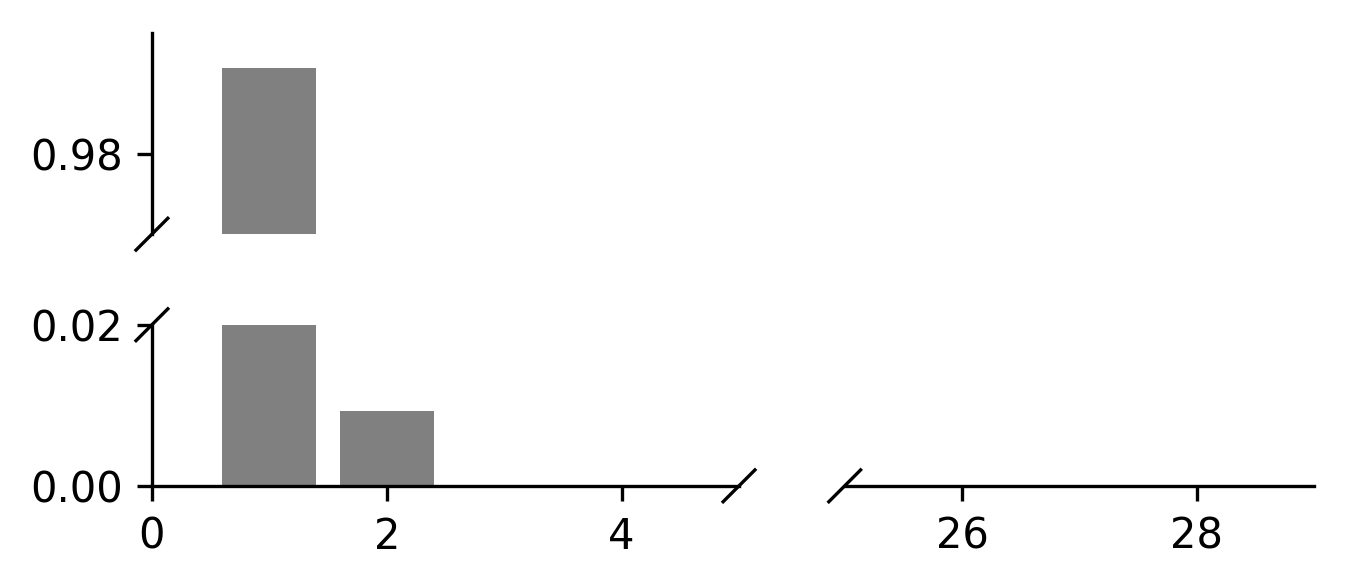

In [12]:
from brokenaxes import brokenaxes
pervar = stmp/np.sqrt(np.sum(stmp**2))
#
fig = plt.figure(figsize=(5,2),dpi=300)
bax = brokenaxes(xlims=((0,5),(25,29)), ylims=((0., .02), (.97, .995)), hspace=.5)
bax.bar(np.arange(1,stmp.shape[0]+1),pervar**2,color='gray')
plt.xlim((1, 29))
plt.show()

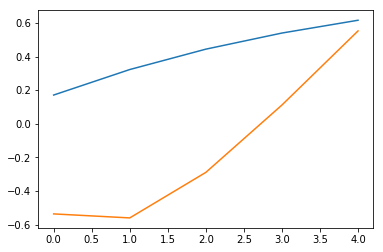

In [15]:
plt.plot(Vhtmp[0:2,:].T)

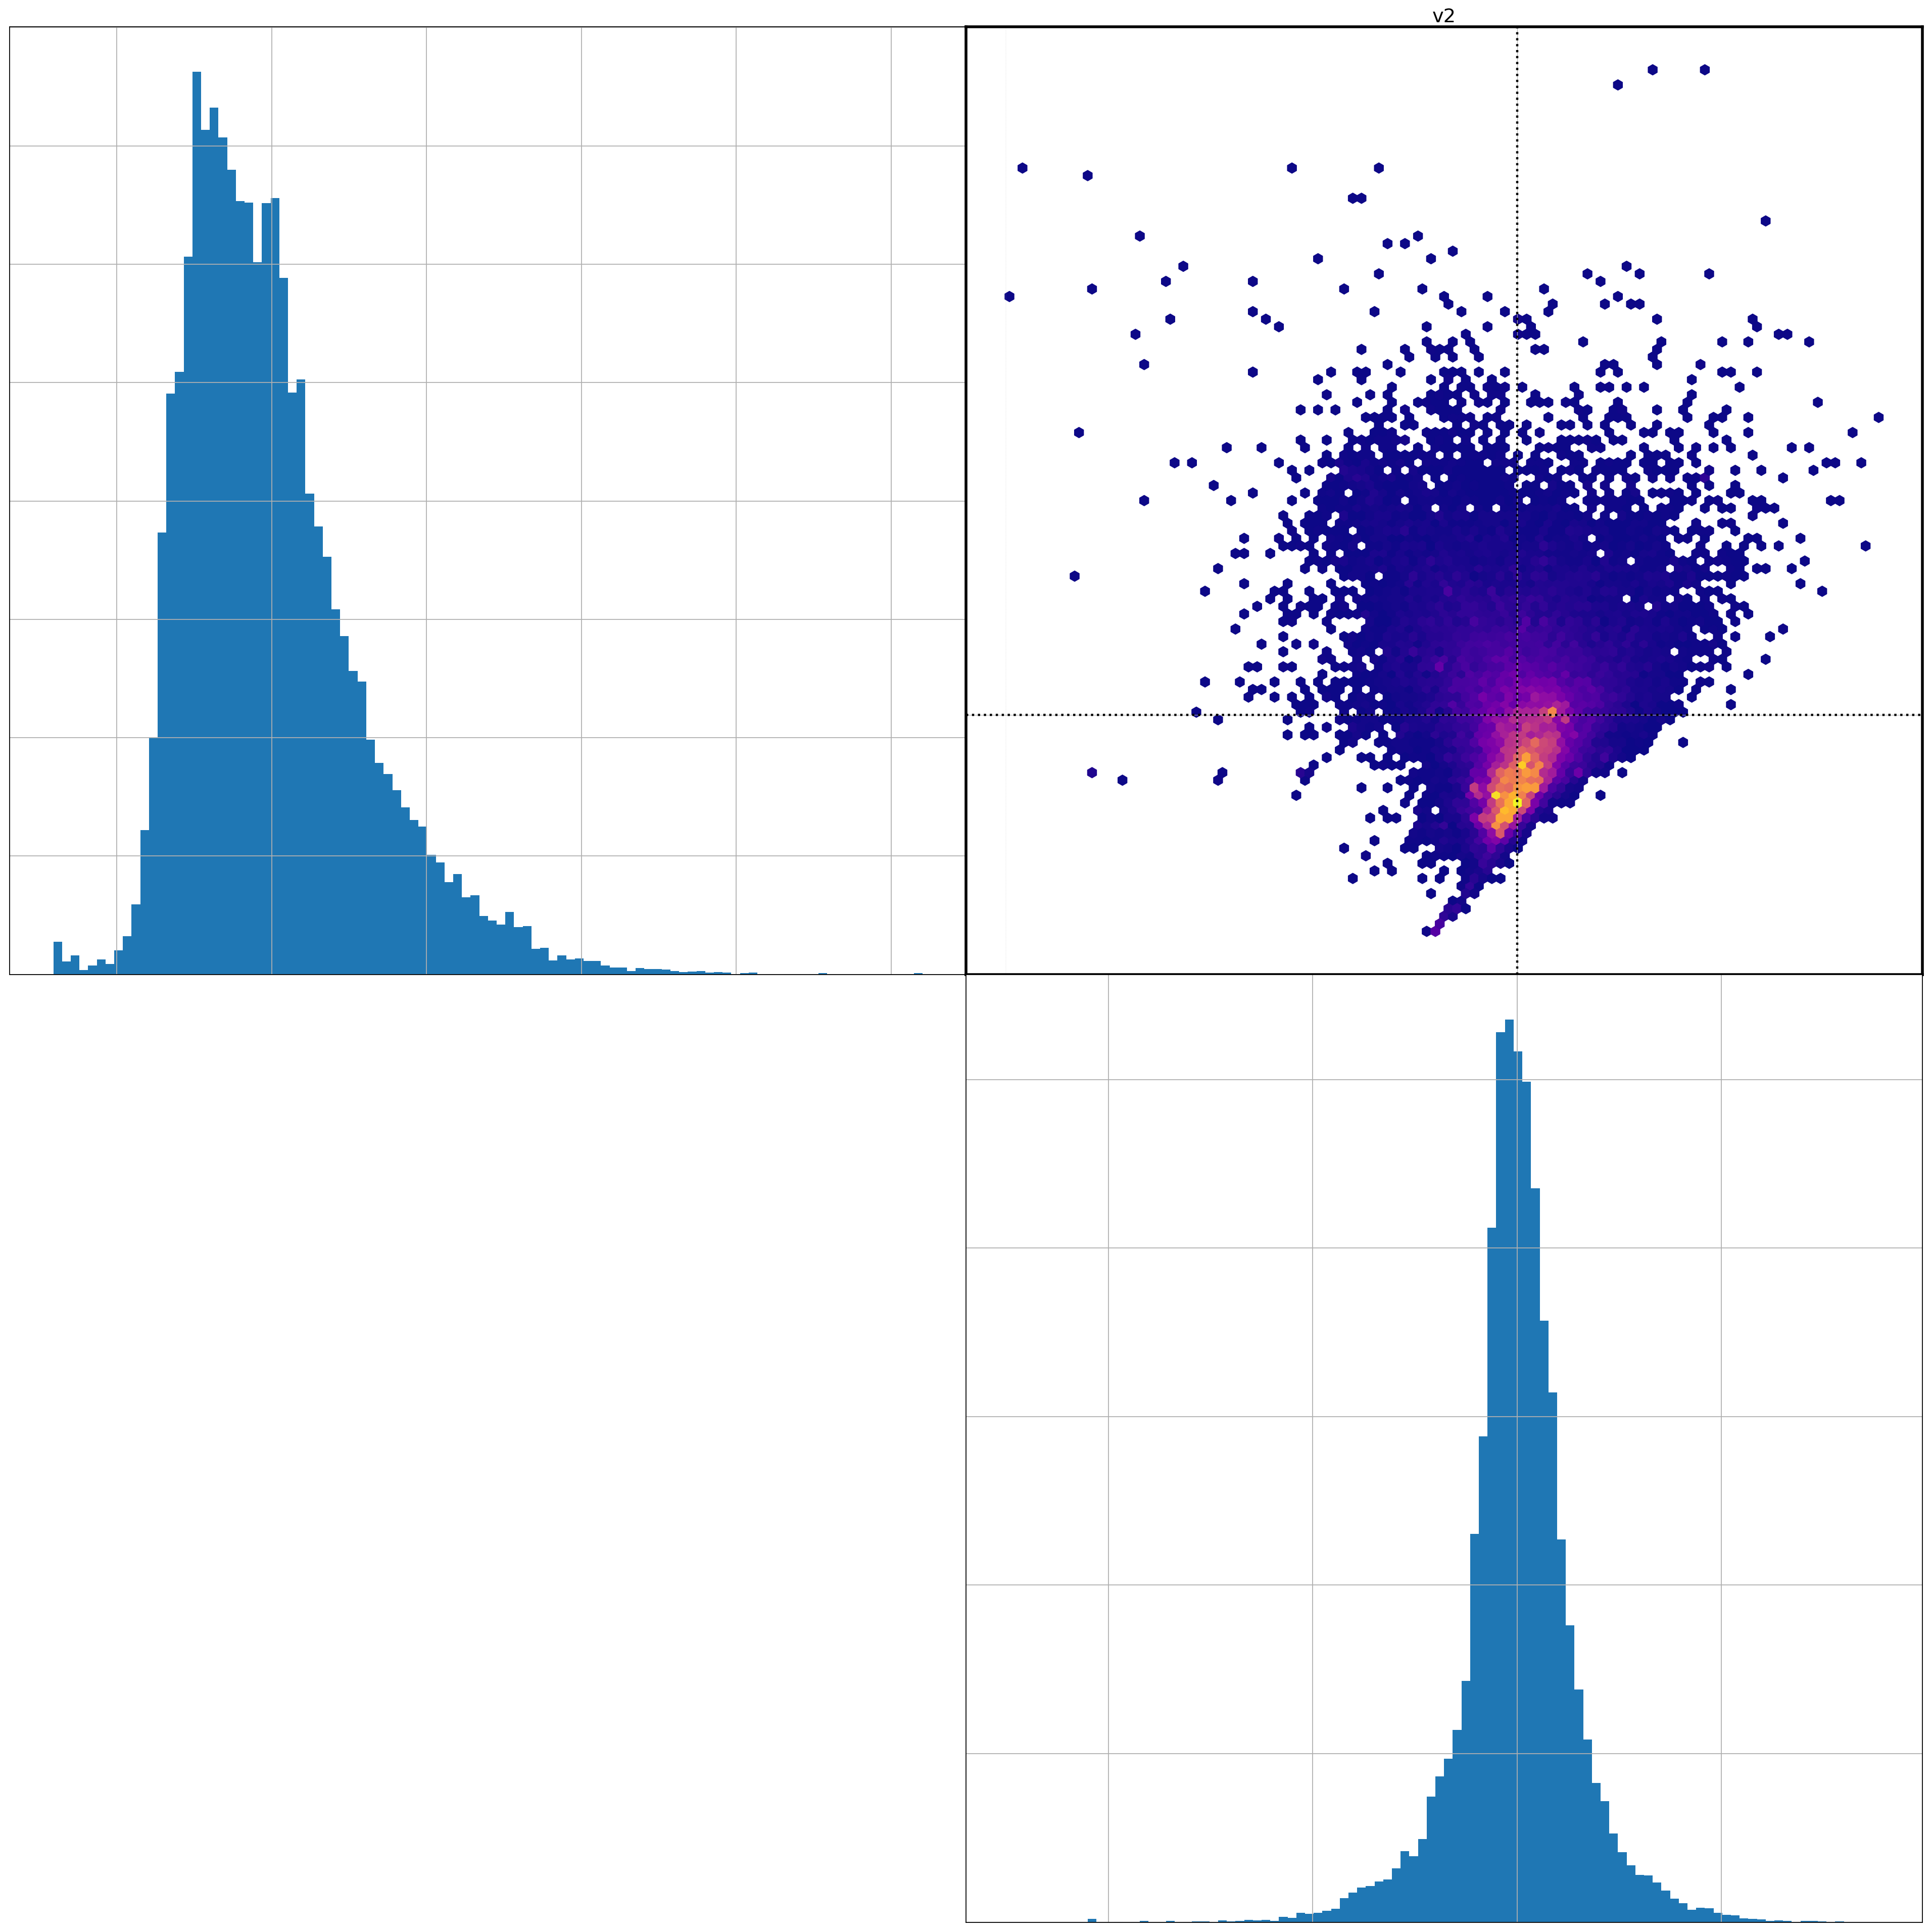

In [16]:
biplots(Utmp[:,0:stmp.shape[0]],n=2,nbins=100)

In [17]:
ndim=2
nbins=10
hist, binedges = np.histogramdd(Utmp[:,0:ndim], bins=nbins)
if ndim == 1:
    binning = np.asarray(binedges[0][:-1]).reshape(nbins,1)
elif ndim == 2:
    X, Y = np.meshgrid(binedges[0][:-1],binedges[1][:-1],indexing='ij')
    binning = np.dstack((X.reshape(nbins**2),Y.reshape(nbins**2)))[0]
elif ndim == 3:
    X, Y, Z = np.meshgrid(binedges[0][:-1],binedges[1][:-1],binedges[2][:-1],indexing='ij')
    binning = np.dstack((X.reshape(nbins**3),Y.reshape(nbins**3),Z.reshape(nbins**3)))[0]

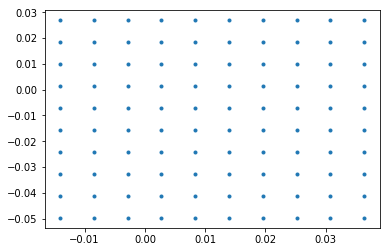

In [22]:
plt.plot(binning[:,0],binning[:,1],'.')

In [23]:
idx_near_centers = get_nearest_to_centers(Utmp[:,0:ndim],binning)

In [53]:
idx_trench = np.where(np.abs(binning[:,0]) < 0.005)
trench = binning[idx_trench,:][0,...]

In [54]:
trench.shape

(20, 2)

In [55]:
idx_near_centers = get_nearest_to_centers(Utmp[:,0:ndim],trench)

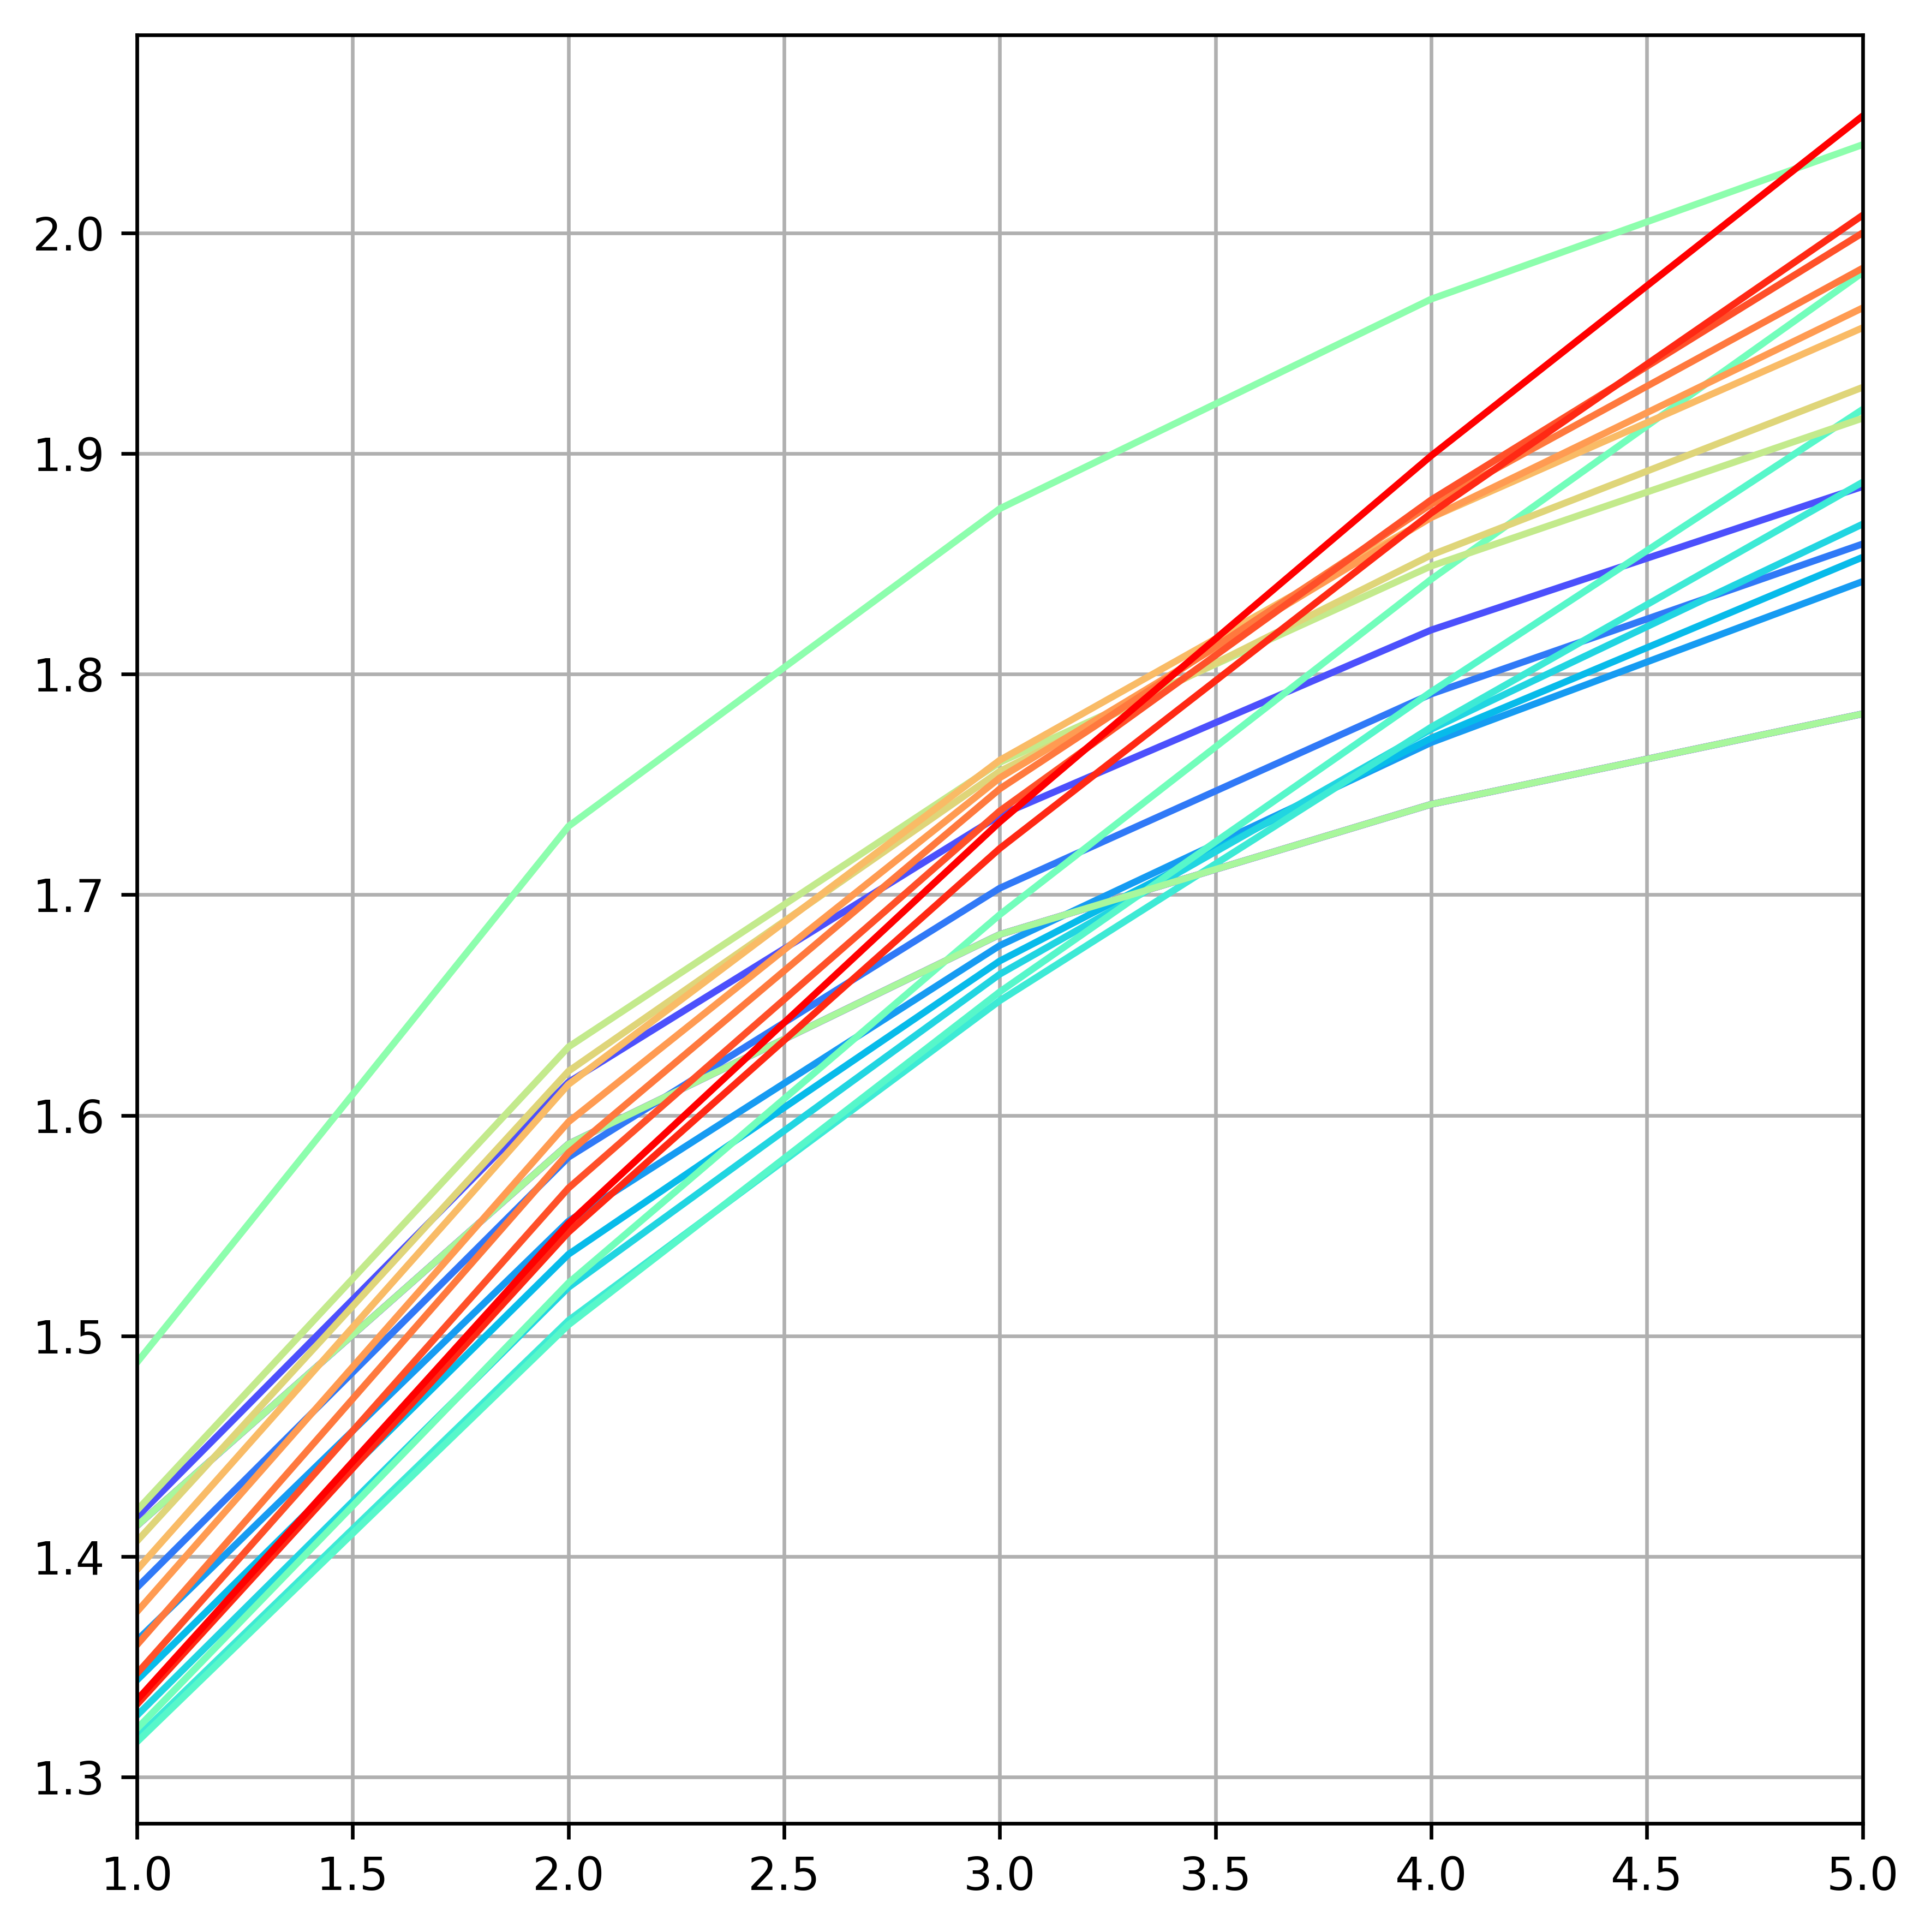

In [56]:
import pylab
cm = pylab.get_cmap('rainbow')
fig = plt.figure(figsize=(6,6),dpi=600)
plt.grid()
labels = []
for i in np.arange(idx_near_centers.shape[0]):
    plt.plot(np.arange(1,Nmax+1),moments_tmp[idx_near_centers[i]],color=cm(1.*i/(nbins*ndim-1)))
plt.xlim((1, Nmax))
plt.tight_layout()
plt.show()

In [58]:
new_ids = ids_2[idx_near_centers]

In [60]:
for i in np.arange(new_ids.shape[0]):
    print(new_ids[i])

193D
193D
1I3W
1ESC
3J0P
1MJI
1BI5
3WTP
4XUL
3K12
1RY1
193D
2M48
2MOX
3EWK
3EZQ
3CHM
3RRL
1QFT
4QPN


## Functions

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
from scipy import linalg
import scipy
import scipy.spatial
import scipy.cluster
from sklearn import mixture

def get_svd(X):
# Singular Value Decomposition
# if traj is (n_sample, n_features), Vh: components. Otherwhise, U
    U,s,Vh = linalg.svd(X)
    return U,s,Vh

def biplots(prj,prj2=None,n=1,plottype='hexbin',nbins=10,figsize=-1,c=None,figname=''):
    """ biplots : plot populations in component space

    Description
    -----------
    For n components, shows biplots between all pairs of prj in upper triangle.
    If prj2 is provided, shows biplots between all pairs of prj2 in lower one.
    The possibility to color based on input assignment is offered.

    """
    show_histo=True
    if c is not None:
        plottype='scatter'
    if(plottype=='scatter'):
        cmap='rainbow'
    else:
        cmap='plasma'
    if(figsize < 0 ):
        if(n == 1):
            figsize=1
        else:
            figsize=4
    figsize=figsize*6
    labels = get_labels(n)
    nrow=n
    ncol=n
    gs = gridspec.GridSpec(nrow, ncol, hspace=0, wspace=0)
    minorticklocator = MultipleLocator(0.1)
    majorticklocator = MultipleLocator(0.2)
    fig = plt.figure(figsize=(figsize,figsize), dpi= 160, facecolor='w', edgecolor='k')
    nbins_coarse = int(nbins/1)
    for i in np.arange(0,nrow,1):
        for j in np.arange(0,ncol,1):
            if(i<j):
                ax = biplot_axis(n,i,j,gs,fig,labels,Ax=prj[:,j],Ay=prj[:,i],c=c,cmap=cmap,nbins=nbins,majortick=0.2,minortick=0.1,linewidth=2.5,plottype=plottype)
            elif(i==j):
                if(show_histo):
                    ax = fig.add_subplot(gs[i,j])
                    plt.grid()
                    plt.tick_params(axis='both', which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False)
                    Ax = prj[:,i]
                    plt.hist(Ax,bins=nbins_coarse)
                    if prj2 is not None:
                        Ay = prj2[:,i]
                        plt.hist(Ay,bins=nbins_coarse,rwidth=0.4)
                else:
                    if(i==0 and c is not None):
                        ax = fig.add_subplot(gs[i,j])
                        ax.set_xlabel(labels[j],fontsize='xx-large')
                        ax.set_ylabel(labels[i],fontsize='xx-large')
                        ax.xaxis.set_label_position('top')
                        for corner in ('top','bottom','right','left'):
                            ax.spines[corner].set_linewidth(0)
                        ax.tick_params(axis='both', which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False,labelsize='large')
                        colorbar = range(1,np.max(c)+1,1)
                        ax.scatter(colorbar, colorbar, c=colorbar, vmin=1, vmax=np.max(c), cmap=cmap)
                        for idx, txt in enumerate(colorbar):
                            ax.annotate(txt,(colorbar[idx],colorbar[idx]))
            else:
                if prj2 is not None:
                    ax = biplot_axis(n,i,j,gs,fig,labels,Ax=prj2[:,j],Ay=prj2[:,i],c=c,cmap=cmap,nbins=nbins,majortick=0.2,minortick=0.1,linewidth=2.5,plottype=plottype)
    plt.tight_layout()
    plt.show()
    if(figname):
        fig.savefig(figname+'_biplot.png')
        
def biplot_axis(n,i,j,gs,fig,labels,Ax=np.zeros(1),Ay=np.zeros(1),c=None,cmap=None,nbins=1,majortick=0.2,minortick=0.1,linewidth=2.5,plottype='scatter'):
    minorticklocator = MultipleLocator(minortick)
    majorticklocator = MultipleLocator(majortick)
    ax = fig.add_subplot(gs[i,j])
    ax.xaxis.set_minor_locator(minorticklocator)
    ax.xaxis.set_major_locator(majorticklocator)
    ax.yaxis.set_minor_locator(minorticklocator)
    ax.yaxis.set_major_locator(majorticklocator)
    for corner in ('top','bottom','right','left'):
        ax.spines[corner].set_linewidth(linewidth)
    ax.minorticks_on()
    ax.grid(which='major',axis='both',linestyle='-',linewidth=0.5)
    ax.grid(which='minor',axis='both',linestyle='--',linewidth=0.1)
    ax.axvline(0, linestyle=':', linewidth=2, color='k')
    ax.axhline(0, linestyle=':', linewidth=2, color='k')
    if(i == 0 and j != n-1):
        ax.set_xlabel(labels[j],fontsize='xx-large')
        ax.xaxis.set_label_position('top')
        if(j==1):
            ax.tick_params(axis='both', which='both',bottom=False,top=False,left=True,right=False,labelbottom=False,labeltop=False,labelleft=True,labelright=False,labelsize='large')
        else:
            ax.tick_params(axis='both', which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False,labelsize='large')
    elif(i == 0 and j == n-1):
        ax.set_xlabel(labels[j],fontsize='xx-large')
        #ax.set_ylabel(labels[i],fontsize='xx-large',rotation=270)
        ax.xaxis.set_label_position('top')
        #ax.yaxis.set_label_position('right')
        ax.tick_params(axis='both', which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False,labelsize='large')
    elif(i != 0 and j == n-1):
        #ax.set_ylabel(labels[i],fontsize='xx-large',rotation=270)
        #ax.yaxis.set_label_position('right')
        ax.tick_params(axis='both', which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False,labelsize='large')
    elif(i < j and i != 0 and j != n-1):
        ax.tick_params(axis='both', which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False,labelsize='large')
    if(j == 0 and i != n-1 ):
        ax.set_ylabel(labels[i],fontsize='xx-large')
        if(i==1):
            ax.xaxis.set_label_position('top')
            ax.tick_params(axis='both', which='both',bottom=False,top=True,left=False,right=False,labelbottom=False,labeltop=True,labelleft=False,labelright=False,labelsize='large')
        else:
            ax.tick_params(axis='both', which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False,labelsize='large')
    elif(j == 0 and i == n - 1):
        #ax.set_xlabel(labels[j],fontsize='xx-large')
        ax.set_ylabel(labels[i],fontsize='xx-large')
        ax.tick_params(axis='both', which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False,labelsize='large')
    elif(j != 0 and i == n-1 ):
        #ax.set_xlabel(labels[j],fontsize='xx-large')
        ax.tick_params(axis='both', which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False,labelsize='large')
    elif(j < i and j !=0 and i != n-1):
        ax.tick_params(axis='both', which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False,labelsize='large')
    if(plottype == 'scatter'):
        ax.scatter(Ax, Ay, c=c, cmap=cmap)
    else:
        ax.hexbin(Ax, Ay, gridsize=nbins, cmap=cmap, mincnt=1)
    return ax


def get_labels(n):
    labels = []
    for i in np.arange(0,n,1):
        labels.append('v'+str(i+1))
    return labels

def cluster(x,weight):
    distance = scipy.spatial.distance.pdist(x, metric='minkowski',p=2,w=weight)
    clusters = scipy.cluster.hierarchy.linkage(distance, method='ward')
    return clusters

def scan_gmm(V,n_components=3,plot=True):
    """
    """
    n_components_range = range(1, n_components+1)
    lowest_bic = np.infty
    bic = []
    for i_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=i_components)
        gmm.fit(V)
        bic.append(gmm.bic(V))
        print(" BIC(",i_components,") = ",bic[-1],end="")
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    bic = np.array(bic)
    if plot:
        plot_vector(bic)
    else:
        print('BIC')
        print(bic)
    return best_gmm,bic

def assign_gmm(V,n_components=2):
    """
    """
    gmm = mixture.GaussianMixture(n_components=n_components)
    gmm.fit(V)
    assignment = gmm.predict(V)
    index = []
    for i in np.arange(0,n_components):
        index.append(np.ma.where(assignment == i))
        print(". component ",i," has ",index[-1][0].shape[0]," particles")
    centers = gmm.means_
    return assignment,index,centers

def get_nearest_to_centers(projs,centers):
    mytree = scipy.spatial.cKDTree(projs)
    dist, indexes = mytree.query(centers)
    return indexes

def plot_cluster(clusters,x,figsize=12,figname=''):
    fig = plt.figure(figsize=(figsize, figsize), dpi= 160, facecolor='w', edgecolor='k')
    nrow=2
    ncol=1
    # look at the number of natural clusters using the linkage object
    plt.subplot(nrow,ncol,1)
    plt.scatter(np.arange(1,len(x)), clusters[:,2][::-1])
    plt.title('Objective function change', fontsize=15)
    plt.ylabel('Variance', fontsize=13)
    plt.xlabel('Number of macrostates', fontsize=13)
    # see dendogram
    plt.subplot(nrow,ncol,2)
    scipy.cluster.hierarchy.dendrogram(clusters, labels=np.arange(len(x)))
    plt.xticks(fontsize=13)
    plt.title('Ward linkage', fontsize=15)
    #
    plt.tight_layout()
    plt.show()
    if(figname):
        fig.savefig(figname+'_cluster.png')
        
def plot_vector(x):
    """
    """
    fig = plt.figure(figsize=(2,2))
    plt.plot(np.arange(1,x.shape[0]+1),x,marker='o',color='black')

def get_assignment(l,n_clusters):
    return scipy.cluster.hierarchy.fcluster(l, t=n_clusters, criterion='maxclust')